# Dependencies 

In [1]:
import numpy as np
import networkx as nx 

from numpy.random import default_rng
from osmnx import graph_from_point
from osmnx_utils import gps_dist, extract_positions, meters_to_gps

from typing import Iterator, Iterable, Tuple, List

# Overview 
Methods in this notebook will allow you to create random circular (circular in terms of meters, elliptical in terms of degrees of latitude and longitude) windows of a graph produced by osmnx. 

## Obtaining a circular graph 
The following functions will allow you to fetch a circlular graph from given (longitude, latitude) coordinates or convert an existing graph, with longitude and latitude present for each node, into a circular one. 

In [2]:
def node_to_position(G: nx.Graph) -> Iterator[Tuple[int, Tuple[float, float]]]:
    """
    Generates nodes along with their corresponding longitude, latitude tuple for the given graph G. 
    Note that the nodes in graph G must have 'x' and 'y' attributes, which is the case when fetching a 
    graph via the osmnx library. 
    """
    for node, attr_dict in G.nodes.data():
        yield node, (attr_dict['x'], attr_dict['y'])
        
        
def nodes_in_radius(G: nx.Graph, center: Tuple[float, float], radius: float) -> Iterator[int]:
    """
    Generates nodes in the graph G whose gps coordinates are within the distance radius 
    of the center coordinates. 
    """
    for node, pos in node_to_position(G=G):
        if gps_dist(np.asarray(center), np.asarray(pos)) <= radius: 
            yield node 
            

def graph_circle(G: nx.Graph, center: Tuple[float, float], radius: float) -> nx.Graph:
    """
    Returns a subgraph of the graph G with only the nodes that are within the distance radius of the 
    center. Keep in mind that the returned graph might not be a single connected component. 
    """
    return G.subgraph(nodes_in_radius(G=G, center=center, radius=radius))


def circle_graph_from_point(point: Tuple[float, float], radius: float) -> nx.Graph:
    """
    Fetch a circular graph of the given radius around the given point (longitude, latitude). You might 
    want to add more arguments to the function definition in order to modify the behaviour of the 
    graph_from_point osmnx function.
    """
    return graph_circle(
        G=graph_from_point((point[1], point[0]), dist=radius), 
        center=point, 
        radius=radius,
    )

def circle_graphs_from_points(points: Iterable[Tuple[float, float]], radius: float) -> Iterator[nx.Graph]:
    """
    Convenience function for calling circle_graph_from_point for multiple points. 
    """
    for point in points:
        yield circle_graph_from_point(point=point, radius=radius)

## Constructing subgraph windows



In [ ]:
import torch_geometric as pyg
import torch_geometric_temporal as pygt 
import numpy as np

from typing import Tuple
from osmnx_utils import gps_dist


def pyg_circle(data: pyg.data.Data, point: Tuple[float, float], radius: float) -> pyg.data.Data:
    attributes = {'x', 'y', 'edge_index', 'edge_attr', 'pos'}
    mask = gps_dist(point, data.pos.numpy()) <= radius 
    return pyg.data.Data(**{attr: getattr(data, attr)[mask] for attr in (attributes & set(dir(data)))})


def pygt_circle(data: pygt.signal.StaticGraphTemporalSignal, point: Tuple[float, float], radius: float)\
-> pygt.signal.StaticGraphTemporalSignal:
    node_mask = gps_dist(point, data.pos[0]) <= radius
    edge_mask = np.isin(data.edge_index.numpy(), node_mask.nonzero).any(axis=0)
    new_pos = data.pos[0][node_mask]
    return pygt.signal.StaticGraphTemporalSignal(
        features=data.features[:, node_mask], 
        targets=data.features[:, node_mask], 
        edge_index=data.edge_index.T[edge_mask].T, 
        edge_weight=data.edge_weight[edge_mask],
        pos=np.broadcast_to(new_pos, (data.snapshot_count, *new_pos.shape))
    )

In [3]:
rng = default_rng(seed=0)


def random_points_in_circle(n: int = 1, root: float = 4, center: Tuple[float, float] = (0, 0), 
                            radius: float = 1) -> np.array:
    """
    Constructs an array of n points in a circle with the given center point and radius. The rotation of 
    the points around the center is distributed uniformly and their distance from the center is given as 
    1/root times the uniform distribution; thus, higher roots will give points biased away from the center, 
    and lower roots biased towards the center. 
    """
    rs = np.power(rng.random(n), 1 / root)
    ts = rng.random(n) * 2 * np.pi
    return np.squeeze(np.column_stack((np.cos(ts), np.sin(ts))) * rs.reshape(-1, 1) * radius + center)


def random_points_in_circle_gps(n: int = 1, root: float = 4, center: Tuple[float, float] = (0, 0), 
                                radius: float = 1) -> np.array:
    """
    A convenience function which functions as random_points_in_circle, but returns points in gps 
    coordinates i.e. (longitude, latitude). 
    """
    return random_points_in_circle(n=n, root=root, center=(0, 0), radius=1) * radius * \
meters_to_gps(center[1]) + center


def largest_connected_component(G: nx.Graph) -> nx.Graph:
    """
    Get the largest connected component of the graph G. 
    """
    return G.subgraph(max(nx.connected_components(G.to_undirected()), key=len))


def approx_center(G: nx.Graph) -> Tuple[float, float]:
    """
    Assumming the graph G is circular, get its center. 
    
    The returned value usually insignificantly differs from the actual center of G; however, the difference
    might be significant if the graph is very sparse. 
    """
    pos = extract_positions(G)
    return (pos.max(axis=0) + pos.min(axis=0)) / 2


def random_circle_subgraphs(G: nx.Graph, center_radius: float, window_radius: float, n: int = 1, 
                            root: float = 4) -> Iterator[nx.Graph]:
    """
    Generates random circular subgraphs of G where centers of the subgraphs are randomly distributed
    within center_radius distance from the center of G and have radius equal to windows_radius. 
    Additionally, the largest connected component of the resulting window is taken; otherwise, the 
    resulting graph may not be connected.
    """
    
    center = approx_center(G=G)
    for point in random_points_in_circle_gps(n=n, root=root, radius=center_radius, center=center):
        yield largest_connected_component(graph_circle(G, center=point, radius=window_radius))

# Example
First we obtain a circlar graph of a part of New Delhi. Then we generate random windows of that graph.

In [4]:
import osmnx as ox 

from matplotlib import pyplot as plt

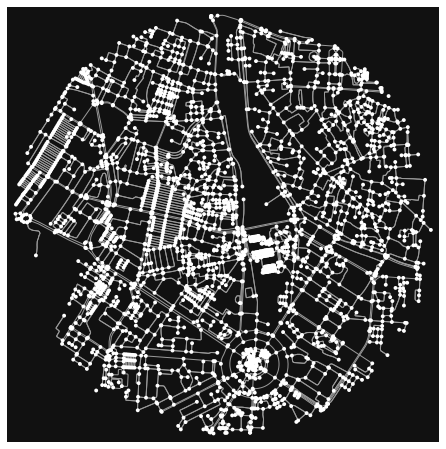

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [5]:
NEW_DELHI_COORDS = 77.216721, 28.644800
RADIUS = 2000

G = circle_graph_from_point(NEW_DELHI_COORDS, radius=RADIUS)
ox.plot_graph(G)

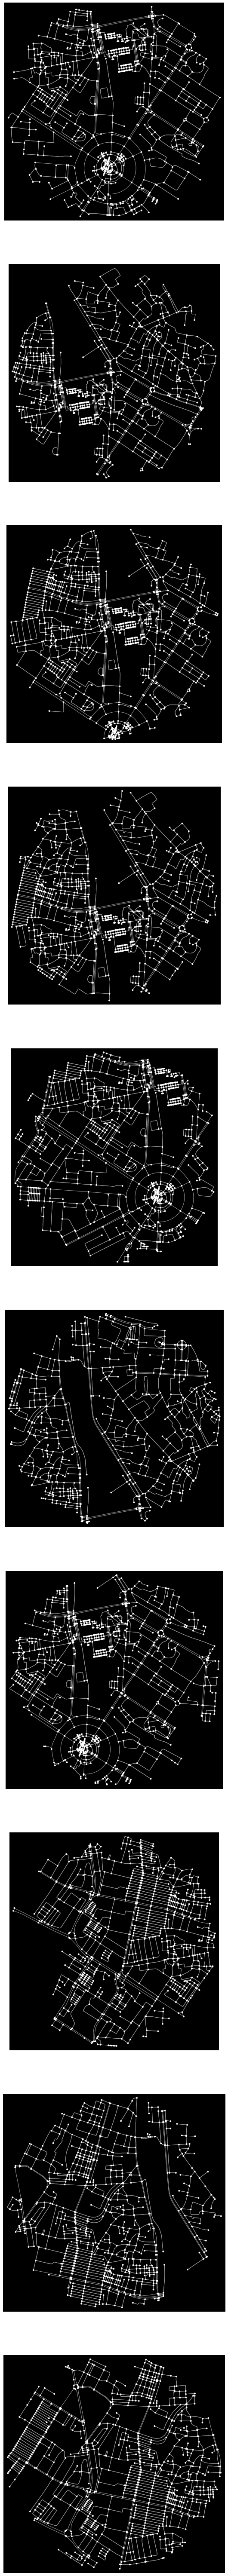

In [6]:
N_WINDOWS = 10
fig, axes = plt.subplots(N_WINDOWS, 1, figsize=(10, 11*N_WINDOWS))

for ax, g in zip(axes, random_circle_subgraphs(
    G=G, center_radius=RADIUS//2, window_radius=RADIUS//2, n=N_WINDOWS)): 
    ox.plot_graph(G=g, ax=ax, close=False, show=False)
    ax.set_facecolor('k')

# Additional functions for PyG and PyGT
Usage shown in the notebook "GNN on city graphs"

In [ ]:
def mask_edge_index(edge_index: ArrayLike, mask: ArrayLike) -> ArrayLike:
    """
    Given a mask of length equal to the second dimension of edge_index, a subset of edge_index will
    be produced according to that mask. Note that when masking an edge_index array, the resulting node
    IDs will likely not begin from 0, or will have a non-unit increment; thus, this function also
    converts the node IDs starting from 0 and increasing by 1, while still preserving the order of the
    nodes.
    """
    edge_index = edge_index.T[mask].T
    for i, v in enumerate(edge_index.unique(sorted=True)):
        edge_index[edge_index == v] = i
    return edge_index


def pyg_circle(data: pyg.data.Data, point: Tuple[float, float], radius: float) -> pyg.data.Data:
    """
    Returns a subset of the data of only the nodes that lay within the radius distance (in meters) from the
    given point (longitude, latitude).
    """
    node_mask = gps_dist(point, data.pos.numpy()) <= radius
    edge_mask = np.isin(data.edge_index.numpy(), node_mask.nonzero()[0]).all(axis=0)
    circle = pyg.transforms.LargestConnectedComponents()(pyg.data.Data(
        x=data.x[node_mask],
        y=data.y[node_mask],
        edge_index=mask_edge_index(edge_index=data.edge_index, mask=edge_mask),
        edge_attr=data.edge_attr[edge_mask],
        pos=data.pos[node_mask],
    ))
    return circle, node_mask, edge_mask


def pygt_circle(data: pygt.signal.StaticGraphTemporalSignal, point: Tuple[float, float], radius: float) \
        -> pygt.signal.StaticGraphTemporalSignal:
    """
    Returns a subset of the data of only the nodes that lay within the radius distance (in meters) from the
    given point (longitude, latitude).
    """
    snapshot, node_mask, _ = pyg_circle(data[0], point=point, radius=radius)
    # Position of nodes does not change in static graph, so the first snapshot may simply be broadcasted
    pos = data.pos[0][node_mask]
    pos = np.broadcast_to(pos, (data.snapshot_count, *pos.shape))
    return pygt.signal.StaticGraphTemporalSignal(
        features=data.features[:, node_mask],
        targets=data.targets[:, node_mask],
        edge_index=snapshot.edge_index,
        edge_weight=snapshot.edge_attr,
        pos=pos,
    )


def random_pygt_circles(data: pygt.signal.StaticGraphTemporalSignal, center_radius: float,
                        circle_radius: float, n: int = 1) \
        -> pygt.signal.StaticGraphTemporalSignal:
    """
    Returns n subsets of the data of only the nodes that lay within the radius distance (in meters) from the
    n randomly generated points (longitude, latitude).
    """
    center = data.pos[0].mean(axis=0)
    for point in random_points_in_circle_gps(center=center, radius=center_radius, n=n):
        yield pygt_circle(data=data, point=point, radius=circle_radius)